# Customer Segmentation

In this project we will try to perform market basket analysis. WE will try to find different clusters of customers based on their spending habits.

# Table of Contents

1. [Load Data](#load-data)
2. [Inspect Data](#inspect-data)
3. [Preprocessing and Cleaning Data](#preprocessing-and-cleaning-data)
4. [EDA (Exploratory Data Analysis)](#eda)
5. [Feature Selection](#feature-selection)
6. [Scaling and Encoding](#scaling-and-encoding)
7. [Hyperparameters Tuning](#hyperparameters-tuning)
8. [Model Building](#model-building)
9. [Evaluation](#evaluation)
10. [Visualize Model](#visualize-model)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

%matplotlib inline
sns.set(style="whitegrid")


## 1. [Load Data](#load-data)

In [2]:
relative_path = 'Mall_Customers.csv'
path = os.path.join(os.getcwd(), relative_path)

df = pd.read_csv(path)
df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## 2. [Inspect Data](#inspect-data)

In [3]:
def inspect(df):
    if isinstance(df, pd.DataFrame):
        print(f'Dimensions: {df.shape[0]} rows and {df.shape[1]} columns.')

        total_na = df.isnull().sum().sum()
        print(f'Number of NA values: {total_na}')

        print(f'%38s %10s %10s %10s' % ('Column Name', 'Data Type', 'Distinct', 'NA Values'))

        col_names = df.columns
        dtypes = df.dtypes
        uniq = df.nunique()
        na_values = df.isna().sum()

        for i in range(len(df.columns)):
            print(f'%38s %10s %10s %10s' % (col_names[i], dtypes[i], uniq[i], na_values[i]))

    else:
        print('Expect a DataFrame but got a %15s' % (type(df)))

inspect(df)


Dimensions: 200 rows and 5 columns.
Number of NA values: 0
                           Column Name  Data Type   Distinct  NA Values
                            CustomerID      int64        200          0
                                Gender     object          2          0
                                   Age      int64         51          0
                    Annual Income (k$)      int64         64          0
                Spending Score (1-100)      int64         84          0


/var/folders/l_/sd90yz351sn2j7ttw4wtv_7h0000gn/T/ipykernel_4825/210517951.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'%38s %10s %10s %10s' % (col_names[i], dtypes[i], uniq[i], na_values[i]))


In [4]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [6]:
df.duplicated().sum()

0

In [7]:
df_check = df.drop(['Gender', 'CustomerID'], axis=1)

for column in df_check.columns:
    number_of_unique_values = df_check[column].nunique()
    print(f'{column}: {number_of_unique_values} unique values')


Age: 51 unique values
Annual Income (k$): 64 unique values
Spending Score (1-100): 84 unique values


In [8]:
for column in df_check.columns:
    max_values = df_check.nlargest(5, column)
    min_values = df_check.nsmallest(5, column)
    print(f'Max values for {column}:')
    print(max_values)
    print(f'Min values for {column}:')
    print(min_values)


Max values for Age:
    Age  Annual Income (k$)  Spending Score (1-100)
60   70                  46                      56
70   70                  49                      55
57   69                  44                      46
67   68                  48                      48
90   68                  59                      55
Min values for Age:
     Age  Annual Income (k$)  Spending Score (1-100)
33    18                  33                      92
65    18                  48                      59
91    18                  59                      41
114   18                  65                      48
0     19                  15                      39
Max values for Annual Income (k$):
     Age  Annual Income (k$)  Spending Score (1-100)
198   32                 137                      18
199   30                 137                      83
196   45                 126                      28
197   32                 126                      74
194   47                 120  

## 3. [Preprocessing and Cleaning Data](#preprocessing-and-cleaning-data)

In [9]:
# Removing spaces in column names
df.columns = [col.replace(' ', '') for col in df.columns]

# Handle missing values if any
df.dropna(inplace=True)

# Drop CustomerID
df_clean = df.drop('CustomerID', axis=1)
df_clean.head()


,Gender,Age,AnnualIncome(k$),SpendingScore(1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


## 4. [EDA (Exploratory Data Analysis)](#eda)


/Users/mjg/anaconda3/envs/ML_Basic/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mjg/anaconda3/envs/ML_Basic/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mjg/anaconda3/envs/ML_Basic/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


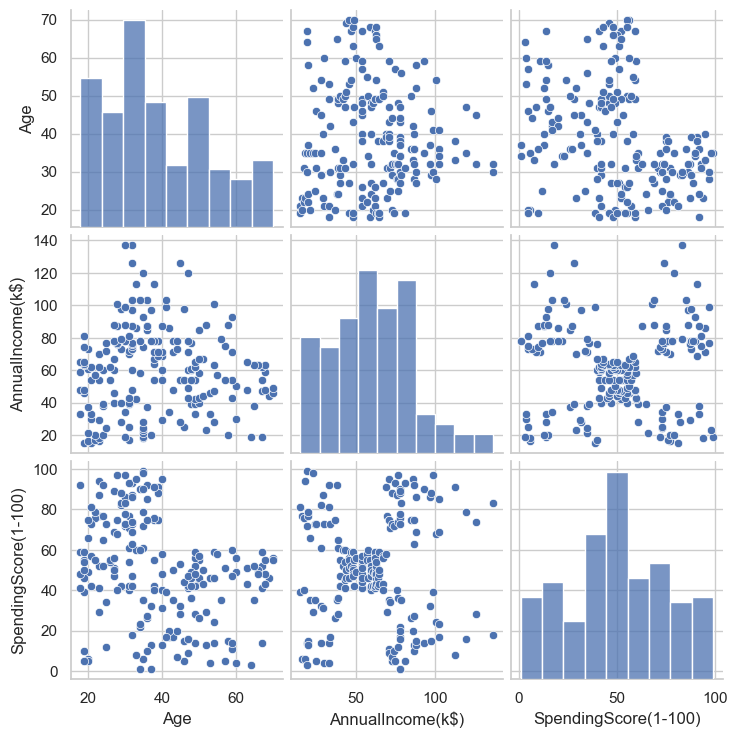

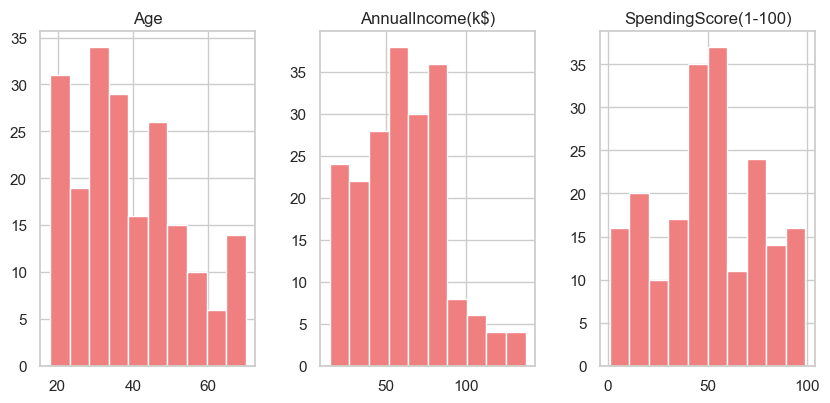

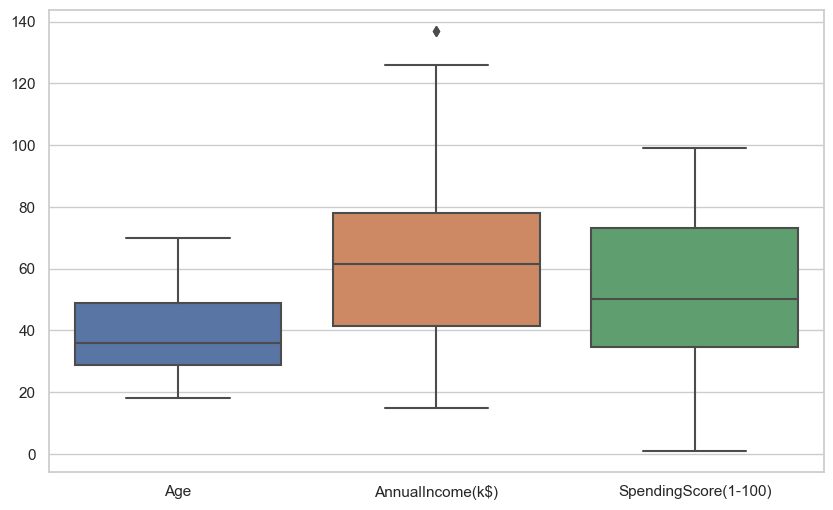

In [10]:
sns.pairplot(df_clean)
df_clean.hist(figsize=(10, 10), color='lightcoral', layout=(2, 3))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean)
plt.show()

# Removing outliers
df_clean = df_clean[df_clean['AnnualIncome(k$)'] <= 130]


## 5. [Feature Selection](#feature-selection)

In [11]:
# Feature selection
features = ['Age', 'AnnualIncome(k$)', 'SpendingScore(1-100)']
X = df_clean[features]


## 6. [Scaling and Encoding](#scaling-and-encoding)

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 7. [Hyperparameters Tuning](#hyperparameters-tuning)

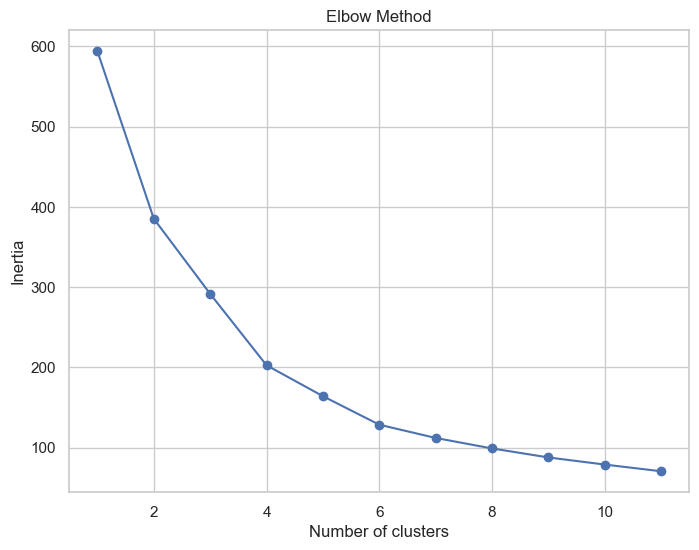

In [13]:
inertias = []

for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 12), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


## 8. [Model Building](#model-building)

In [38]:
kmeansmodel = KMeans(n_clusters=6, init='k-means++', random_state=0, n_init=10)
y_kmeans = kmeansmodel.fit_predict(X_scaled)

# Adding cluster labels to the dataframe
df_clean['Cluster'] = y_kmeans
df_clean.head()


,Gender,Age,AnnualIncome(k$),SpendingScore(1-100),Cluster,Cluster_PCA,Cluster_GMM,Cluster_DBSCAN,Cluster_Best
0,Male,19,15,39,4,3,5,-1,4
1,Male,21,15,81,4,3,2,0,4
2,Female,20,16,6,5,0,5,-1,5
3,Female,23,16,77,4,3,2,0,4
4,Female,31,17,40,5,3,5,-1,5


## 9. [Evaluation](#evaluation)

In [39]:
silhouette_avg = silhouette_score(X_scaled, y_kmeans)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.4338361973846591


## 10. [Visualize Model](#visualize-model)

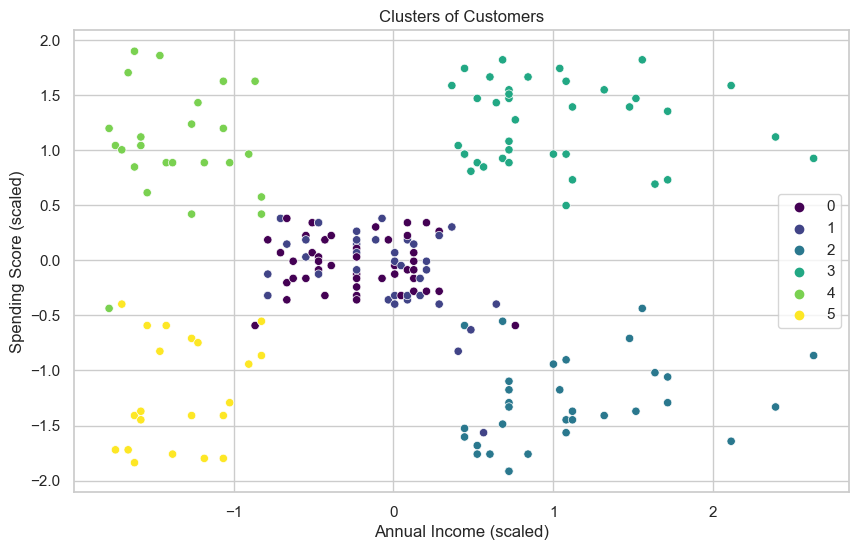

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=y_kmeans, palette='viridis')
plt.title('Clusters of Customers')
plt.xlabel('Annual Income (scaled)')
plt.ylabel('Spending Score (scaled)')
plt.legend()
plt.show()


## 11. [Improving the Model](#improving-the-model)

In [41]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# KMeans with PCA components
kmeans_pca = KMeans(n_clusters=6, init='k-means++', random_state=0, n_init=10)
y_kmeans_pca = kmeans_pca.fit_predict(X_pca)

# Adding PCA cluster labels to the dataframe
df_clean['Cluster_PCA'] = y_kmeans_pca

# Evaluation
silhouette_avg_pca = silhouette_score(X_pca, y_kmeans_pca)
print("Silhouette Score after PCA:", silhouette_avg_pca)


Silhouette Score after PCA: 0.3815558207019095


## 12. [Additional Clustering Methods](#additional-clustering-methods)

Silhouette Score with GMM: 0.38017871287299965


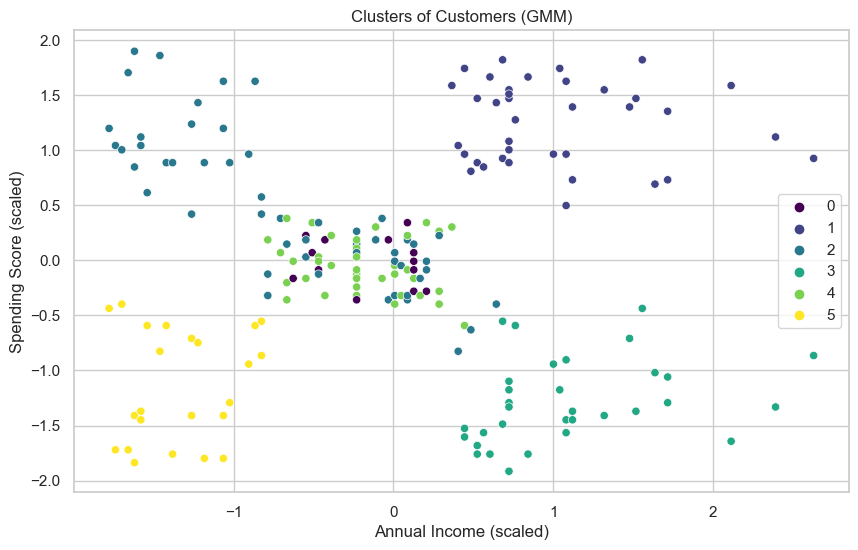

In [42]:
from sklearn.mixture import GaussianMixture

# Fit GMM
gmm = GaussianMixture(n_components=6, random_state=0)
y_gmm = gmm.fit_predict(X_scaled)

# Evaluation
silhouette_avg_gmm = silhouette_score(X_scaled, y_gmm)
print("Silhouette Score with GMM:", silhouette_avg_gmm)

# Adding GMM cluster labels to the dataframe
df_clean['Cluster_GMM'] = y_gmm

# Visualization of GMM Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=y_gmm, palette='viridis')
plt.title('Clusters of Customers (GMM)')
plt.xlabel('Annual Income (scaled)')
plt.ylabel('Spending Score (scaled)')
plt.legend()
plt.show()


Silhouette Score with DBSCAN: 0.5171651181583379


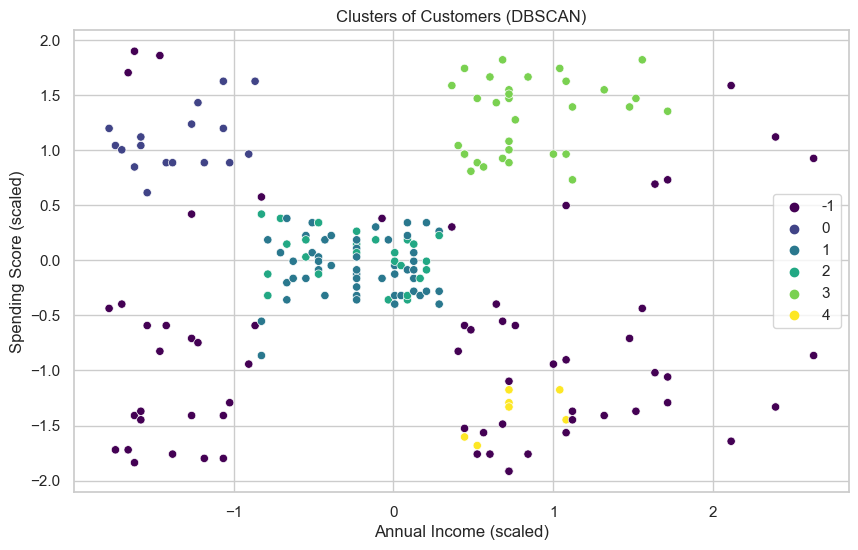

In [43]:
from sklearn.cluster import DBSCAN

# Fit DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_dbscan = dbscan.fit_predict(X_scaled)

# Evaluation
# Note: DBSCAN assigns -1 to noise points, so we filter them out for silhouette score calculation
labels = y_dbscan[y_dbscan != -1]
core_samples_mask = (y_dbscan != -1)
silhouette_avg_dbscan = silhouette_score(X_scaled[core_samples_mask], labels)
print("Silhouette Score with DBSCAN:", silhouette_avg_dbscan)

# Adding DBSCAN cluster labels to the dataframe
df_clean['Cluster_DBSCAN'] = y_dbscan

# Visualization of DBSCAN Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=y_dbscan, palette='viridis')
plt.title('Clusters of Customers (DBSCAN)')
plt.xlabel('Annual Income (scaled)')
plt.ylabel('Spending Score (scaled)')
plt.legend()
plt.show()


In [44]:
# Testing different number of clusters and initialization methods
best_score = 0
best_params = {}
inertias = []

for n_clusters in range(2, 15):
    for init_method in ['k-means++', 'random']:
        kmeans = KMeans(n_clusters=n_clusters, init=init_method, random_state=0, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        inertias.append(kmeans.inertia_)
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_params = {'n_clusters': n_clusters, 'init': init_method}

# Display best parameters and score
print("Best Silhouette Score:", best_score)
print("Best Parameters:", best_params)

# Build the best model
kmeans_best = KMeans(n_clusters=best_params['n_clusters'], init=best_params['init'], random_state=0, n_init=10)
y_kmeans_best = kmeans_best.fit_predict(X_scaled)
df_clean['Cluster_Best'] = y_kmeans_best


Best Silhouette Score: 0.4338361973846591
Best Parameters: {'n_clusters': 6, 'init': 'k-means++'}


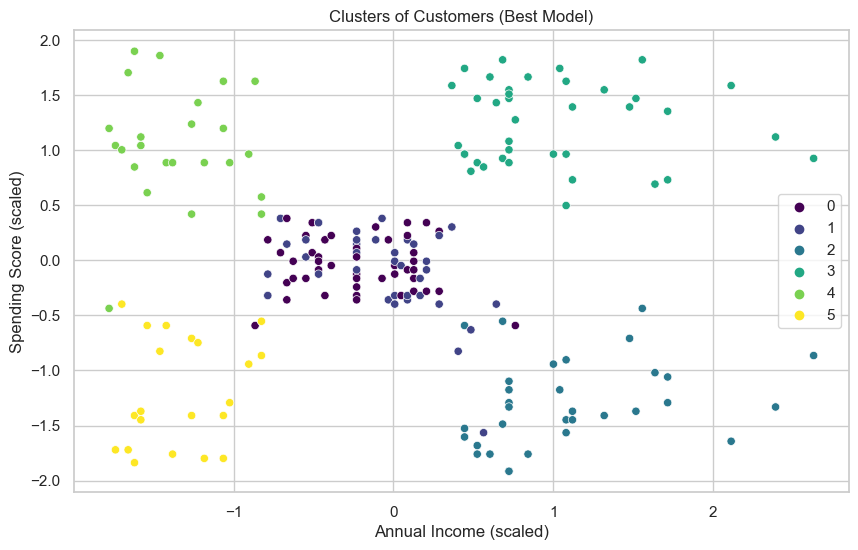

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=y_kmeans_best, palette='viridis')
plt.title('Clusters of Customers (Best Model)')
plt.xlabel('Annual Income (scaled)')
plt.ylabel('Spending Score (scaled)')
plt.legend()
plt.show()
